## 1. 소규모 데이터셋으로 만드는 강력한 학습 모델

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Activation, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 기존 이미지  갯수 늘리기:전처리
train_data_gen = ImageDataGenerator(rescale=1./255,            # 정규화
                                   horizontal_flip=True,       # 수평 뒤집기
                                   width_shift_range=0.1,       # 수평 이동
                                   height_shift_range=0.1,      # 수직이동
                                   fill_mode='nearest')
train_generator = train_data_gen.flow_from_directory('./data/train', target_size=(150, 150), batch_size=5, class_mode='binary')

test_data_gen = ImageDataGenerator(rescale=1./255)  # 테스트 데이터는 정규화만
test_generator = test_data_gen.flow_from_directory('./data/test', target_size=(150, 150), batch_size=5, class_mode='binary')

Found 160 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [3]:
model = Sequential()
model.add(Conv2D(32, kernel_size=3, input_shape=(150, 150, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 activation (Activation)     (None, 36, 36, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        1

In [4]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002), metrics=['accuracy'])

erary_stop = EarlyStopping(patience=5)

history = model.fit(train_generator, epochs=200, validation_data=test_generator, validation_steps=10, callbacks=[erary_stop])

Epoch 1/200
32/32 [==============================] - 6s 132ms/step - loss: 0.6987 - accuracy: 0.4750 - val_loss: 0.6865 - val_accuracy: 0.5400
Epoch 2/200
32/32 [==============================] - 4s 123ms/step - loss: 0.6851 - accuracy: 0.5625 - val_loss: 0.6782 - val_accuracy: 0.6200
Epoch 3/200
32/32 [==============================] - 4s 122ms/step - loss: 0.6830 - accuracy: 0.5375 - val_loss: 0.6641 - val_accuracy: 0.5800
Epoch 4/200
32/32 [==============================] - 4s 122ms/step - loss: 0.6793 - accuracy: 0.6062 - val_loss: 0.6437 - val_accuracy: 0.7200
Epoch 5/200
32/32 [==============================] - 4s 122ms/step - loss: 0.6418 - accuracy: 0.7063 - val_loss: 0.5687 - val_accuracy: 0.8400
Epoch 6/200
32/32 [==============================] - 4s 123ms/step - loss: 0.6091 - accuracy: 0.6875 - val_loss: 0.5505 - val_accuracy: 0.7000
Epoch 7/200
32/32 [==============================] - 4s 119ms/step - loss: 0.6063 - accuracy: 0.7375 - val_loss: 0.4762 - val_accuracy: 0.8600

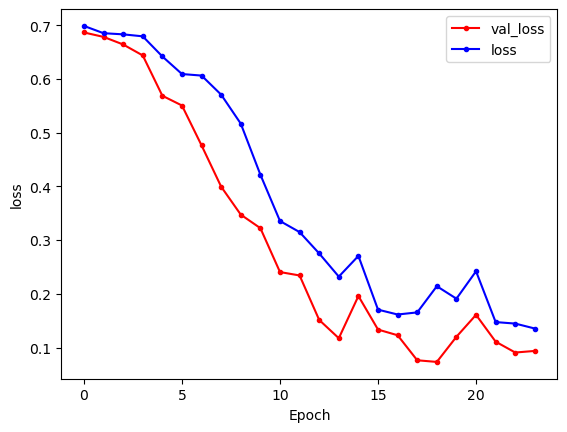

In [5]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']
x_num = np.arange(len(y_vloss))

plt.plot(x_num, y_vloss, marker='.', c='red', label='val_loss')
plt.plot(x_num, y_loss, marker='.', c='blue', label='loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='best')
plt.show()

## 2. 전이학습으로 모델 성능 극대화하기

In [7]:
from tensorflow.keras import optimizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras import optimizers, Input, models, metrics

In [9]:
transfer_model = VGG16(input_shape=(150, 150, 3), include_top=False)
transfer_model.trainable = False
transfer_model.summary()

58889256/58889256 [==============================] - 35s 1us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                             

In [10]:
model = Sequential()
model.add(transfer_model)
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                524352    
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 15,239,105
Trainable params: 524,417
Non-trainable params: 14,714,688
_________________________________________________________________


In [11]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002), metrics=['accuracy'])
earl_stop = EarlyStopping(patience=5)
history = model.fit(train_generator, epochs=200, validation_data=test_generator, validation_steps=10, callbacks=[earl_stop])

Epoch 1/200
32/32 [==============================] - 16s 481ms/step - loss: 0.6639 - accuracy: 0.6187 - val_loss: 0.5279 - val_accuracy: 0.7400
Epoch 2/200
32/32 [==============================] - 15s 471ms/step - loss: 0.6179 - accuracy: 0.6250 - val_loss: 0.4633 - val_accuracy: 0.9200
Epoch 3/200
32/32 [==============================] - 18s 567ms/step - loss: 0.4416 - accuracy: 0.8250 - val_loss: 0.3888 - val_accuracy: 0.9000
Epoch 4/200
32/32 [==============================] - 18s 554ms/step - loss: 0.3772 - accuracy: 0.9000 - val_loss: 0.3364 - val_accuracy: 0.9000
Epoch 5/200
32/32 [==============================] - 17s 531ms/step - loss: 0.3158 - accuracy: 0.8875 - val_loss: 0.3832 - val_accuracy: 0.8200
Epoch 6/200
32/32 [==============================] - 17s 530ms/step - loss: 0.3158 - accuracy: 0.8813 - val_loss: 0.2969 - val_accuracy: 0.9000
Epoch 7/200
32/32 [==============================] - 17s 541ms/step - loss: 0.2786 - accuracy: 0.9062 - val_loss: 0.2031 - val_accuracy:

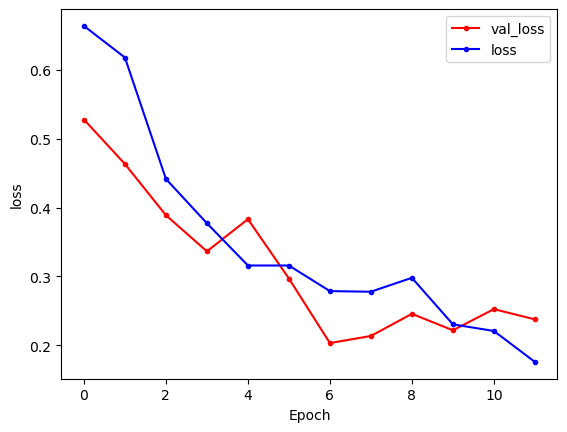

In [12]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']
x_num = np.arange(len(y_vloss))

plt.plot(x_num, y_vloss, marker='.', c='red', label='val_loss')
plt.plot(x_num, y_loss, marker='.', c='blue', label='loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='best')
plt.show()